# Machine Learning Foundation

## Section 2, Part C: Cross Validation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [3]:
import requests

def download(url, filename):
    response = requests.get(url)
    
    print(f"content {response}")
    if response.status_code == 200:
        with open(filename,'wb') as f:
            f.write(response.content)

## Data loading

In [4]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"

download(url, 'boston_housing_clean.pickle')

content <Response [200]>


In [5]:
boston = pd.read_pickle('./boston_housing_clean.pickle')
boston.keys()

dict_keys(['dataframe', 'description'])

In [6]:
boston_data = boston['dataframe']
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?


In [7]:
y_col_name = 'MEDV'
X = boston_data.drop(y_col_name, axis=1)
y = boston_data[y_col_name]

In [8]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [9]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [10]:
for train_index, test_index in kf.split(X):
    print(f"train_index: {train_index[:10]}, {len(train_index)}")
    print(f"test_index: {test_index[:10]}, {len(test_index)}")
    print(f"\n")

train_index: [ 1  3  4  5  7  8 10 11 12 13], 337
test_index: [ 0  2  6  9 15 17 19 23 25 26], 169


train_index: [ 0  2  6  9 10 11 12 13 15 17], 337
test_index: [ 1  3  4  5  7  8 14 16 22 27], 169


train_index: [0 1 2 3 4 5 6 7 8 9], 338
test_index: [10 11 12 13 18 20 21 24 28 31], 168




In [11]:
scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    score = r2_score(y_test.values, y_pred)
    scores.append(score)

scores

[0.6719348798472742, 0.7485020059212382, 0.6976807323597771]

In [12]:
scores = []

lr = LinearRegression()
sc = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    X_train_s = sc.fit_transform(X_train)
    lr.fit(X_train_s, y_train)
    X_test_s = sc.transform(X_test)
    y_pred = lr.predict(X_test_s)
    score = r2_score(y_test.values, y_pred)
    scores.append(score)

scores

[0.6719348798472715, 0.7485020059212382, 0.6976807323597745]

## Using Pipeline and cross_val_predict

In [13]:
s = StandardScaler()
lr = LinearRegression()
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [14]:
estimator = Pipeline([('scaler', s),
                      ('regression', lr)])

In [15]:
predictions = cross_val_predict(estimator, X, y, cv=kf)
r2_score(y, predictions)
np.mean(scores)

0.7060392060427615

## Hyperparameter Tuning

In [16]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [17]:
scores = []
coefs = []

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ('scaler', s),
        ('lasso_regression', las)])
    
    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

In [18]:
list(zip(alphas, scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052063),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884888)]

In [19]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [20]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

Text(0, 0.5, '$R^2$')

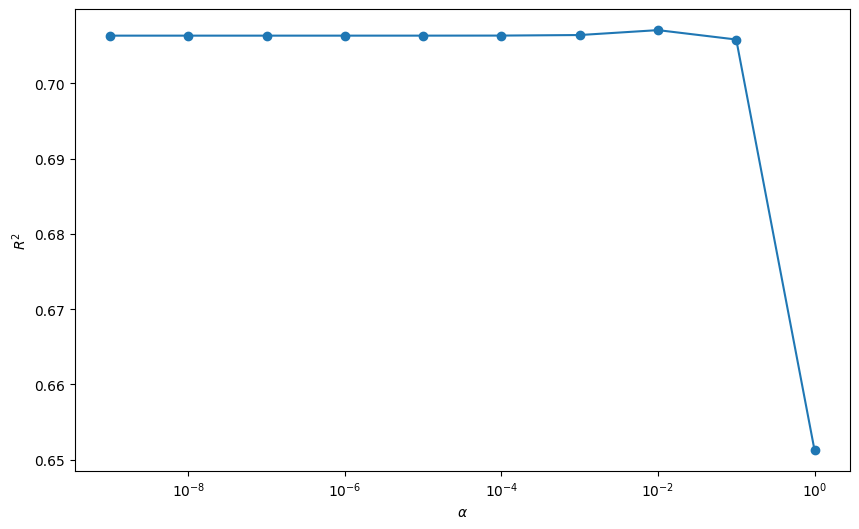

In [21]:
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')

### Polynomial Features

In [22]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ('scaler', s),
        ('make_higher_degree', pf),
        ('lasso_regression', las)
    ])
    
    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

scores

[0.8109754662476154,
 0.8224863637940227,
 0.8230573042903306,
 0.8143160953048915,
 0.8044446338622657,
 0.7942423307179223,
 0.7837829963261633,
 0.7762405981594626,
 0.77008630147054,
 0.7696545891092781,
 0.7629213902351794,
 0.746362920338825,
 0.7222912862089705,
 0.695253921882193,
 0.6715160557453473,
 0.6324054431232764,
 0.580589840077772,
 0.5046557947726654,
 0.41425023203661404,
 0.3800935078061405]

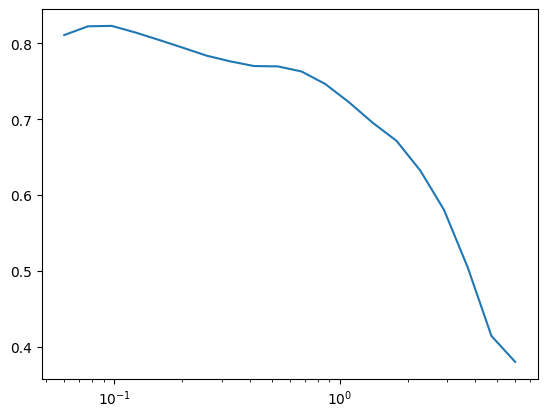

In [23]:
plt.semilogx(alphas, scores)

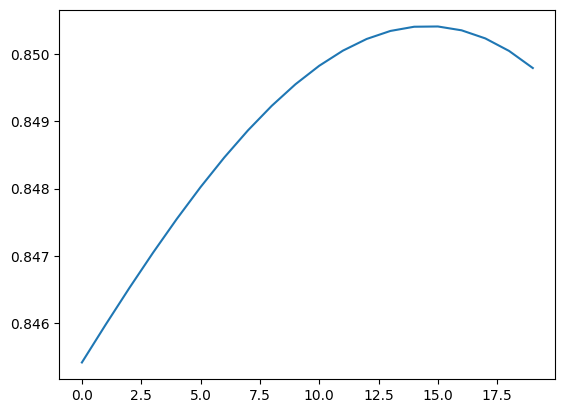

In [24]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ('scaler', s),
        ('polynomial_features', pf),
        ('ridge_regression', ridge)
    ])
    
    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score =  r2_score(y, predictions)
    scores.append(score)


plt.plot(scores)

# Exercise

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


In [25]:
best_estimator = Pipeline([
    ('scaler', s),
    ('make_higher_degree', PolynomialFeatures(degree=2)),
    ('lasso_regression', Ridge(alpha=14))
])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9156283865924145

In [26]:
df_importances = pd.DataFrame(
    zip(best_estimator.named_steps['make_higher_degree'].get_feature_names_out(),
        best_estimator.named_steps['lasso_regression'].coef_
        )
)

In [27]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [28]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [29]:
df_importances.sort_values(by=1)

,0,1
13,x12,-3.047500
8,x7,-2.015940
94,x8 x12,-1.140949
83,x6 x12,-1.140272
98,x9 x12,-1.095473
...,...,...
84,x7^2,1.048402
79,x6 x8,1.122496
96,x9 x10,1.338369
17,x0 x3,1.811323


## Grid Search CV

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


In [30]:
from sklearn.model_selection import GridSearchCV

estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial_features', PolynomialFeatures()),
    ('ridge_regression', Ridge())
])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 20)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [31]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.3535936 ,  4.73844431,  5.15731521,  5.61321363,
        6.10941274,  6.64947505,  7.23727802,  7.87704182,  8.57335972,
        9.331231  , 10.1560969 , 11.05387963, 12.03102491, 13.09454827,
       14.25208539, 15.51194695, 16.88317825, 18.37562421, 20.        ])})

In [32]:
grid.best_score_, grid.best_params_

(0.8504992740007818,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 15.511946948525646})

In [33]:
y_predict = grid.predict(X)

In [34]:
r2_score(y, y_predict)

0.9146985287463713

In [35]:
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00, -1.28829772e-01, -5.05856284e-03,  1.62658971e-02,
        1.00085587e-01, -9.67012834e-01,  3.25919745e+00, -9.57354081e-01,
       -1.94774304e+00,  8.47932375e-01, -1.00903101e+00, -7.09489284e-01,
        5.48320825e-01, -3.02796163e+00,  7.69588769e-02,  7.24274286e-02,
        6.75359501e-02,  1.70458885e+00, -4.76779943e-01,  5.72065384e-01,
        1.29769211e-01,  2.25908428e-01, -7.39176477e-01,  1.64401016e-01,
       -7.79048916e-02, -8.46238751e-02,  4.98683957e-01,  2.15472338e-01,
       -1.47172451e-01,  1.44110784e-01,  1.95181246e-01,  5.12046833e-02,
       -1.10854296e-01, -2.73868352e-01, -1.31082729e-01,  7.19564832e-01,
        5.48148586e-02,  8.81408420e-02, -2.65489851e-01,  5.80545185e-01,
        1.07454993e-01,  9.49069101e-01,  5.68679067e-01,  5.32690017e-01,
        6.98752649e-01, -5.91389648e-02,  7.43093700e-02, -4.26375257e-01,
        2.35823244e-01, -6.82554161e-01,  3.39870567e-01, -9.60949439e-01,
       -8.12827100e-01,  

In [36]:
grid.cv_results_

{'mean_fit_time': array([0.00622471, 0.00817569, 0.00636617, 0.00748801, 0.00862217,
        0.00640694, 0.0082376 , 0.00806125, 0.00914629, 0.00767962,
        0.00793187, 0.00803685, 0.00709224, 0.01126369, 0.01812339,
        0.00927782, 0.00795102, 0.00653394, 0.00899577, 0.00910354,
        0.08927568, 0.07170002, 0.04361494, 0.04478057, 0.04898691,
        0.05084197, 0.05257694, 0.05789002, 0.05236578, 0.04878497,
        0.03716095, 0.04188569, 0.05530016, 0.07167403, 0.06552712,
        0.05481021, 0.08433239, 0.05313508, 0.04486752, 0.04493078,
        0.0754652 , 0.17751034, 0.23314977, 0.07319117, 0.15516353,
        0.06829619, 0.0651114 , 0.07377084, 0.06594237, 0.16699163,
        0.10546907, 0.05365801, 0.12387896, 0.09588758, 0.09879128,
        0.07745314, 0.08512402, 0.17564845, 0.07360617, 0.07838806]),
 'std_fit_time': array([9.87263217e-04, 1.37686448e-04, 1.57969806e-03, 1.89742943e-03,
        2.12253495e-03, 6.27324917e-04, 2.29067395e-03, 1.74293788e-03,
     